# Data report for the acute neurotox dataset for LNA gapmers

This dataset was sourced from https://doi.org/10.1089/nat.2021.0071. A study to investigate acute neurotoxicity of LNA gapmers. The data here are readouts from a spontaneous calcium oscillation cellular assay, validated to be predictive of in vivo outcomes. Low calcium oscillation scores are associated with acute neurotoxicity.

In [3]:
from oligogym.data import DatasetDownloader
from oligogym.features import KMersCounts
from oligogym.models import RandomForestModel
from oligogym.metrics import regression_metrics
from oligogym.stats import get_cosine_dist_to_nearest_neighbor, get_outliers
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Processed dataset

In [4]:
downloader = DatasetDownloader()
dataset = downloader.download("acute_neurotox_lna")
dataset.data.head()

,x,y,y_raw,targets,smiles,fasta
0,RNA1{[lna](A)[sp].[lna](A)[sp].[lna](A)[sp].d(...,80.17,80.17,Control,Cc1cn([C@H]2C[C@H](OP(=O)(S)OC[C@H]3O[C@@H](n4...,AAATCTATAATAACCACCAC
1,RNA1{[lna](C)[sp].[lna](A)[sp].[lna](A)[sp].[l...,88.84,88.84,Control,Cc1cn([C@H]2C[C@H](OP(=O)(S)OC[C@H]3O[C@@H](n4...,CAAATCATCCATCTATAAAC
2,RNA1{[lna](T)[sp].[lna](A)[sp].[lna](C)[sp].d(...,76.53,76.53,Control,Cc1cn([C@@H]2O[C@@]3(CO)CO[C@@H]2[C@@H]3OP(=O)...,TACCATACAATAACTTTAAC
3,RNA1{[lna](C)[sp].[lna](T)[sp].[lna](A)[sp].[l...,79.26,79.26,Control,Cc1cn([C@@H]2O[C@@]3(COP(=O)(S)O[C@H]4[C@H]5OC...,CTAAATCCTTAATATCAAAC
4,RNA1{[lna](C)[sp].d(C)[sp].[lna](A)[sp].[lna](...,80.17,80.17,Control,Cc1cn([C@H]2C[C@H](OP(=O)(S)OC[C@H]3O[C@@H](n4...,CCAAATCTTATAATAACTAC


## Features statistics

In [5]:
dataset.get_helm_stats()

,avg_nt_seq_len,combined_unique_monomers,avg_GC_content,avg_G_content,avg_C_content,avg_A_content,avg_TU_content,num_duplicates
0,17.796164,"[A, C, G, T, d, lna, sp]",40.82445,12.689327,34.479787,26.849703,32.325847,13


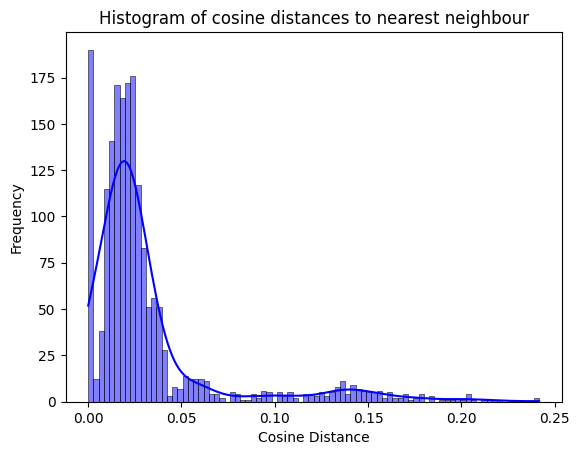

In [6]:
cosine_distances = get_cosine_dist_to_nearest_neighbor(dataset.x)

fig, ax = plt.subplots()

sns.histplot(cosine_distances, ax=ax, color='blue', kde=True)

ax.set_title('Histogram of cosine distances to nearest neighbour')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Frequency')

plt.show()

In [7]:
number_similar_sequences = np.sum(cosine_distances == 0)
print(f"{number_similar_sequences} ASOs have cosine distance to NN of zero when measured using 1 to 5 mers frequency count")

97 ASOs have cosine distance to NN of zero when measured using 1 to 5 mers frequency count


In [8]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="nucleobase", random_state=42)
cosine_dist_nucleobase = get_cosine_dist_to_nearest_neighbor(X_train,X_test)

X_train, X_test, y_train, y_test = dataset.split(split_strategy="random", random_state=42)
cosine_dist_random = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

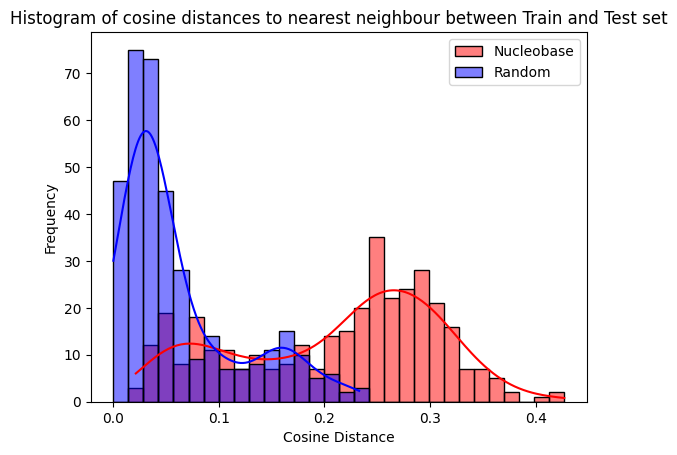

In [9]:
data_min = min(min(cosine_dist_random), min(cosine_dist_nucleobase))
data_max = max(max(cosine_dist_random), max(cosine_dist_nucleobase))

num_bins = 30
bin_edges = np.linspace(data_min, data_max, num_bins+1)

fig, ax = plt.subplots()

sns.histplot(cosine_dist_nucleobase, ax=ax, color='red', kde=True, label='Nucleobase', bins=bin_edges)
sns.histplot(cosine_dist_random, ax=ax, color='blue', kde=True, label='Random', bins=bin_edges)

ax.set_title('Histogram of cosine distances to nearest neighbour between Train and Test set')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Frequency')

ax.legend()
plt.show()

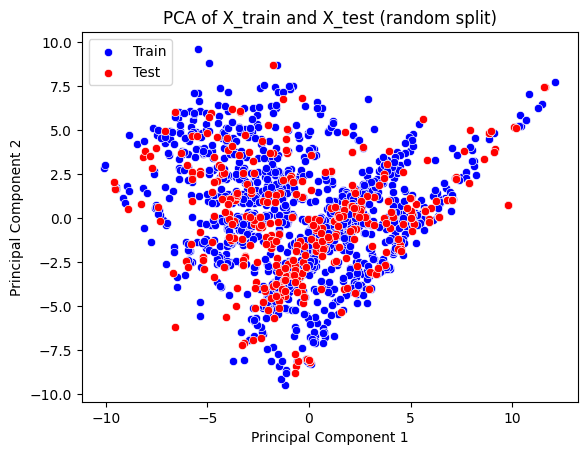

In [10]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="random", random_state=42)
cosine_dist_nucleobase = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

featurizer = KMersCounts(k=[1, 2, 3])
X_train = featurizer.fit_transform(X_train)
X_test = featurizer.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

fig, ax = plt.subplots()
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], ax=ax, color='blue', label='Train')
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], ax=ax, color='red', label='Test')

ax.set_title('PCA of X_train and X_test (random split)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()

plt.show()

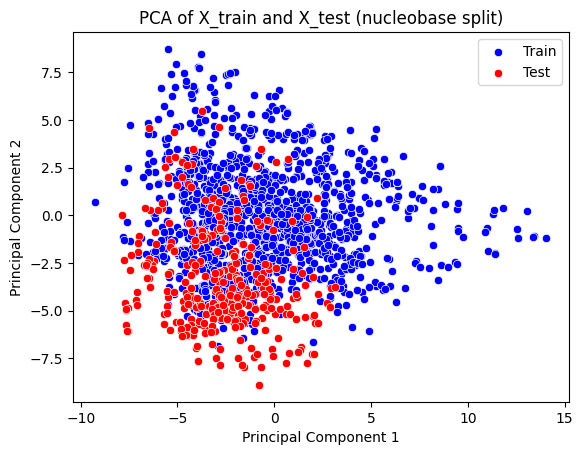

In [11]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="nucleobase", random_state=42)
cosine_dist_nucleobase = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

featurizer = KMersCounts(k=[1, 2, 3])
X_train = featurizer.fit_transform(X_train)
X_test = featurizer.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

fig, ax = plt.subplots()
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], ax=ax, color='blue', label='Train')
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], ax=ax, color='red', label='Test')

ax.set_title('PCA of X_train and X_test (nucleobase split)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()

plt.show()

## Labels statistics

In [12]:
dataset.get_label_stats()

,nobs,minmax,mean,variance,skewness,kurtosis,num_zeros
0,1825,"(0.0, 200.0)",61.351507,1512.729403,0.563308,0.928894,138


In [13]:
print(f"{len(get_outliers(dataset.y))} datapoints are identified as outliers by IQR method")

31 datapoints are identified as outliers by IQR method


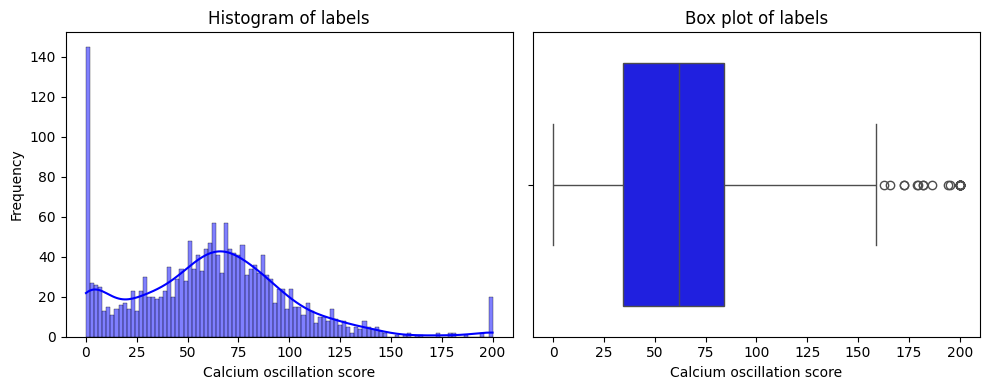

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(dataset.y, ax=axs[0], color='blue', kde=True, bins=100)
axs[0].set_title('Histogram of labels')
axs[0].set_xlabel('Calcium oscillation score')
axs[0].set_ylabel('Frequency')

sns.boxplot(x=dataset.y, ax=axs[1], color='blue')
axs[1].set_title('Box plot of labels')
axs[1].set_xlabel('Calcium oscillation score')

plt.tight_layout()
plt.show()

# Clustering analysis

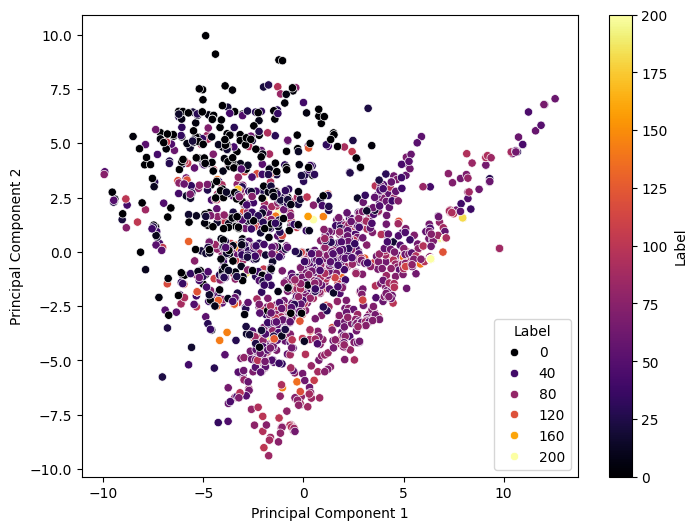

In [15]:
featurizer = KMersCounts(k=[1, 2, 3])
X_kmers = featurizer.fit_transform(dataset.x)

pca = PCA(n_components=2)
X_kmers_pca = pca.fit_transform(X_kmers)

fig, ax = plt.subplots(1 ,1, figsize=(8, 6))
sns.scatterplot(x=X_kmers_pca[:, 0], y=X_kmers_pca[:, 1], hue=dataset.y, ax=ax, palette='inferno')
norm = plt.Normalize(dataset.y.min(), dataset.y.max())
sm = plt.cm.ScalarMappable(cmap="inferno", norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Label')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend(title="Label")

plt.show()

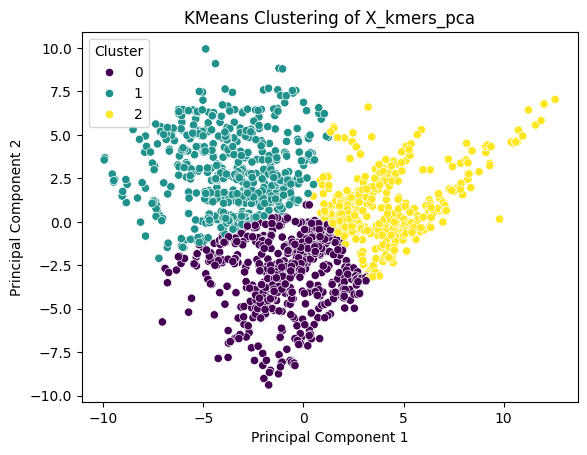

In [16]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_kmers_pca)

# Plot the clusters
fig, ax = plt.subplots()
sns.scatterplot(x=X_kmers_pca[:, 0], y=X_kmers_pca[:, 1], hue=clusters, palette='viridis', ax=ax)
ax.set_title('KMeans Clustering of X_kmers_pca')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

Let's figure out which features differ the most between the different clusters.

In [17]:
cluster_means = X_kmers.groupby(clusters).mean()
feature_differences = cluster_means.diff().abs().iloc[1]
sorted_feature_differences = feature_differences.sort_values(ascending=False)
print(sorted_feature_differences.head(10))

G     3.599419
A     2.359770
C     2.235689
CA    1.277567
TG    1.266274
AA    1.185073
CC    1.174795
AC    1.140999
GG    1.119488
GT    0.990456
Name: 1, dtype: float64


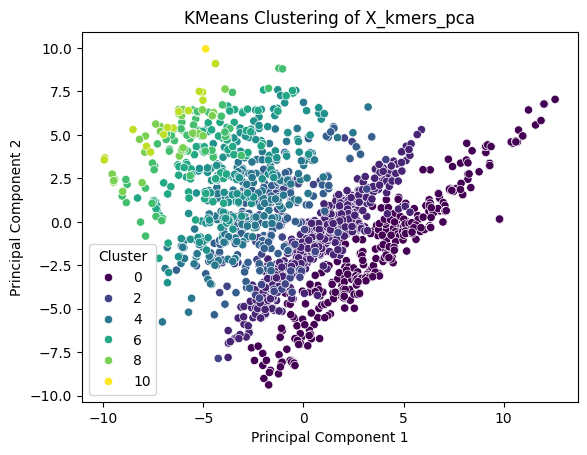

In [18]:
# Plot the clusters
fig, ax = plt.subplots()
sns.scatterplot(x=X_kmers_pca[:, 0], y=X_kmers_pca[:, 1], hue=X_kmers['G'].values, palette='viridis', ax=ax)
ax.set_title('KMeans Clustering of X_kmers_pca')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

We can also do this by looking at the features that are most important for classifying the clusters.

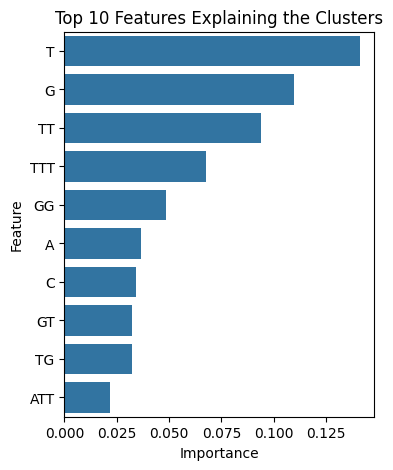

In [19]:
importances = RandomForestClassifier(random_state=42).fit(X_kmers, clusters).feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': X_kmers.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(4, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Features Explaining the Clusters')
plt.show()

# Predictability analysis

In [20]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="random", random_state=42)
featurizer = KMersCounts(k=[1, 2, 3])
X_train = featurizer.fit_transform(X_train)
X_test = featurizer.transform(X_test)

model = RandomForestModel(task="regression")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
metrics_train = regression_metrics(y_train, y_pred_train)
metrics = regression_metrics(y_test, y_pred)
print(metrics_train)
print(metrics)


{'r2_score': 0.8728531054616759, 'root_mean_squared_error': 13.975893666364087, 'mean_absolute_error': 8.402470760378058, 'pearson_correlation': 0.9403228438653304, 'spearman_correlation': 0.960226665097728}
{'r2_score': 0.4300574517025578, 'root_mean_squared_error': 28.34343152370021, 'mean_absolute_error': 20.71444508782831, 'pearson_correlation': 0.6731938763254846, 'spearman_correlation': 0.6694593309642178}


## Recommendation for dataset

The sequences seems to be quite similar at the nucleobase level. From reading through the original publication (https://doi.org/10.1089/nat.2021.0071), it doesn't seem to be an intentional design choice so it might be a result of the target sequences having similar submotif. A trained ML model would probably be used to make prediction for ASO with different nucleobase sequences (as determined by the new target) while the LNA/phosphorothioate backbone design will remain similar. Therefore, a nucleobase data splitting stretgy is recommended. The labels seems quite well distributed. Although quite a number of compound (138) have a score of zeros, this could be due to the way the calcium oscillation score is calculated. These compounds are kept but care should be taken during model evaluation to make sure that performance are not inflated by correctly predicting a lot of zero score. Some outliers were identified but does not seems to deviate too much from the main distribution so are also kept. The final dataset are cleaned up by removing control and duplicate sequences.

In [21]:
downloader=DatasetDownloader()
dataset=downloader.download("acneuTox_lna")
cleaned_dataset=dataset.data.loc[dataset.data['targets'] != 'Control']
cleaned_dataset = cleaned_dataset.drop_duplicates(subset='x', keep='first')

print(f"{len(dataset.data)-len(cleaned_dataset)} datapoints removed")

26 datapoints removed
